Project Name: **💡 AI-Powered Game Response Generator Using Seq2Seq Model! 🚀**

**Import Neccessary Libraries**

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import json

import networkx as nx

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Step 1: Load the Dataset

In [121]:
# Load the Json Dataset
with open('/content/seq2seq_game_data.json', 'r') as file:
    game_data = json.load(file)

In [122]:
# Convert the Json dataset into dataframe
df = pd.DataFrame(game_data)
print('Dataset Sample')
df.head()

Dataset Sample


,input,response,next_options
0,start,You wake up in a mysterious forest. Do you go ...,"[left, right]"
1,left,You find an old abandoned house. Do you 'enter...,"[enter, ignore]"
2,right,You reach a river with a broken bridge. Do you...,"[swim, turn back]"
3,enter,"Inside the house, you see a staircase and a da...","[up, down]"
4,ignore,You continue walking and find a cave. Do you '...,"[enter, walk past]"


# Step 2: Data Preprocessing

In [123]:
# Extract unique choice for encoding
all_text = df['input'].tolist() + df['response'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

206

In [124]:
# Add special tokens
tokenizer.word_index['<start>'] = vocab_size
tokenizer.word_index['<end>'] = vocab_size + 1
vocab_size += 2  # Update vocabulary size

In [125]:
tokenizer.word_index

{'you': 1,
 'a': 2,
 'the': 3,
 'find': 4,
 'and': 5,
 'do': 6,
 'or': 7,
 'to': 8,
 'ignore': 9,
 'it': 10,
 '🎉': 11,
 'house': 12,
 'win': 13,
 'hidden': 14,
 'game': 15,
 'over': 16,
 '💀': 17,
 'enter': 18,
 'back': 19,
 'way': 20,
 'but': 21,
 'treasure': 22,
 'keep': 23,
 "'enter'": 24,
 "'ignore'": 25,
 'with': 26,
 'door': 27,
 'walk': 28,
 'walking': 29,
 'return': 30,
 'explore': 31,
 'key': 32,
 'for': 33,
 'in': 34,
 'island': 35,
 "'explore'": 36,
 'village': 37,
 'note': 38,
 'magical': 39,
 'passage': 40,
 'portal': 41,
 'dragon': 42,
 'turn': 43,
 'inside': 44,
 "back'": 45,
 'well': 46,
 'up': 47,
 'rest': 48,
 'read': 49,
 'hide': 50,
 'away': 51,
 'build': 52,
 'raft': 53,
 'another': 54,
 'avoid': 55,
 'an': 56,
 'basement': 57,
 'further': 58,
 'leads': 59,
 "it'": 60,
 'secret': 61,
 'escape': 62,
 'safely': 63,
 'artifact': 64,
 'become': 65,
 'nearby': 66,
 'gold': 67,
 'chance': 68,
 'locked': 69,
 'nothing': 70,
 'swim': 71,
 'talk': 72,
 'people': 73,
 'wake':

In [126]:
# Encode sequence
X = tokenizer.texts_to_sequences(df['input'])
y = tokenizer.texts_to_sequences(df['response'])

In [127]:
# padding
X = pad_sequences(X, padding='post')
y = pad_sequences(y, padding='post')

In [128]:
X.shape

(68, 4)

In [129]:
y.shape

(68, 20)

# Step 3: Visualization

In [130]:
for index, row in df.iterrows():
  print(index, row)

0 input                                                       start
response        You wake up in a mysterious forest. Do you go ...
next_options                                        [left, right]
Name: 0, dtype: object
1 input                                                        left
response        You find an old abandoned house. Do you 'enter...
next_options                                      [enter, ignore]
Name: 1, dtype: object
2 input                                                       right
response        You reach a river with a broken bridge. Do you...
next_options                                    [swim, turn back]
Name: 2, dtype: object
3 input                                                       enter
response        Inside the house, you see a staircase and a da...
next_options                                           [up, down]
Name: 3, dtype: object
4 input                                                      ignore
response        You continue walking and

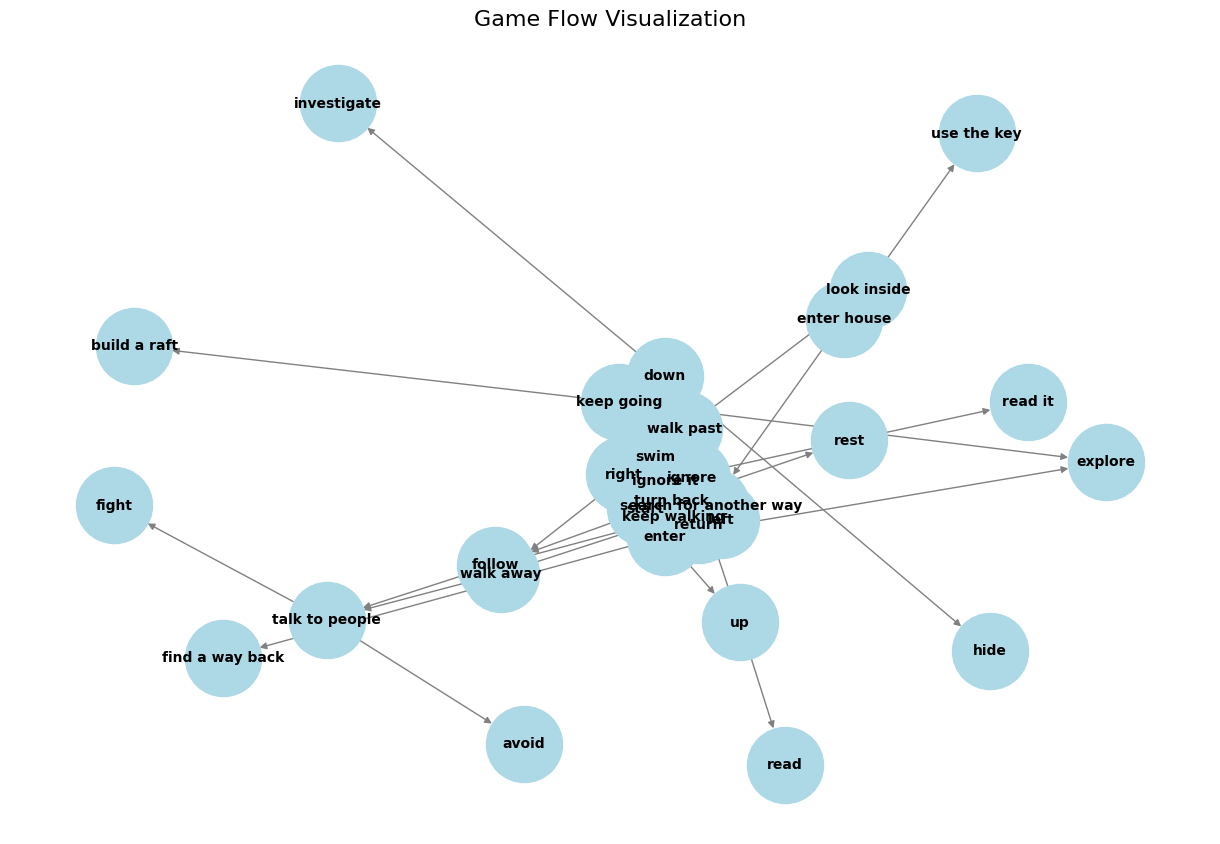

In [131]:
# Create a directed graph to represent the game flow
G = nx.DiGraph()

# Add nodes and edges based on the dataset
for index, row in df.iterrows():
    G.add_node(row['input'], description=row['response'])
    for option in row['next_options']:
        G.add_edge(row['input'], option)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Game Flow Visualization", fontsize=16)
plt.show()

# Step 4: Define Seq2Seq Model

In [132]:
# Prepare decoder input (shifted version of y)
decoder_input_data = np.zeros_like(y)  # Shape: (68, 20)
decoder_input_data[:, 1:] = y[:, :-1]  # Shift right by one time step
decoder_input_data[:, 0] = tokenizer.word_index['<start>']  # Add start token

In [133]:
X.shape[1]

4

In [134]:
embedding_dim = 100
units = 128  #lstm

In [135]:
# Encoder
encoder_inputs = Input(shape=(X.shape[1],))  # Shape: (None, 4)
encoder_embedding = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

In [136]:
# Decoder
decoder_inputs = Input(shape=(y.shape[1],))  # Shape: (None, 20)
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [140]:
# Compile Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [141]:
print("Model Summary:")
model.summary()

Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 4, 100)         │         20,800 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 20, 100)        │         20,800 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ [(None, 128), (None,   │        117,248 │ embedding_10[0][0]     │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, 20, 128),      │        117,248 │ embedding_11[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_10[0][1],         │
│                           │ 128)]                  │                │ lstm_10[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 20, 208)        │         26,832 │ lstm_11[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 302,928 (1.16 MB)

 Trainable params: 302,928 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

# Step 5: Train the Model

In [143]:
X_train = X
y_train = y  # Shape: (68, 20)

history = model.fit([X_train, decoder_input_data], y_train, epochs=100, validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5149 - loss: 2.1723 - val_accuracy: 0.4929 - val_loss: 2.4121
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5159 - loss: 2.1488 - val_accuracy: 0.4964 - val_loss: 2.3980
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5237 - loss: 2.1583 - val_accuracy: 0.4929 - val_loss: 2.3855
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5287 - loss: 2.1173 - val_accuracy: 0.4929 - val_loss: 2.3717
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5170 - loss: 2.1352 - val_accuracy: 0.4893 - val_loss: 2.3548
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5327 - loss: 2.0905 - val_accuracy: 0.5000 - val_loss: 2.3406
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5461 - loss: 2.0581 - val_accuracy: 0.5036 - val_loss: 2.3272
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5410 - loss: 2.0428 - val_accuracy: 0.5143 - v

# Step 6: User Interface for Interaction

In [151]:
def predict_response(user_input):
    # Encode the input sequence
    seq = tokenizer.texts_to_sequences([user_input])
    seq = pad_sequences(seq, maxlen=X.shape[1], padding='post')  # Shape: (1, 4)

    # Initialize the decoder input with the <start> token
    decoder_input = np.zeros((1, y.shape[1]))  # Shape: (1, 20)
    decoder_input[0, 0] = tokenizer.word_index['<start>']  # Set the first token to <start>

    # Generate the response word by word
    response = []
    for i in range(y.shape[1] - 1):  # Iterate over the sequence length
        prediction = model.predict([seq, decoder_input], verbose=0)  # Predict the next word
        predicted_index = np.argmax(prediction[0, i, :])  # Get the predicted word index

        # Stop if <end> token is predicted
        if predicted_index == tokenizer.word_index['<end>']:
            break

        # Skip padding tokens (0)
        if predicted_index == 0:
            continue

        # Append the predicted word
        response.append(tokenizer.index_word[predicted_index])

        # Update the decoder input
        decoder_input[0, i + 1] = predicted_index

    return ' '.join(response)

In [154]:
print("\nGame Started! Type 'exit' to quit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        break
    response = predict_response(user_input)
    print("Bot:", response)


Game Started! Type 'exit' to quit.
You: start
Bot: you find a hidden passage behind a bookshelf do you 'enter' or 'ignore' it
You: enter
Bot: the passage leads to a dark dungeon do you 'explore' or 'turn back'
You: explore
Bot: you find a hidden passage behind a bookshelf do you 'enter' or 'ignore' it
You: enter
Bot: the passage leads to a dark dungeon do you 'explore' or 'turn back'
You: exit
